# Multi-Task Learning Model for Category Learning Experiment

This notebook outlines the steps to create and train a multi-task learning model for a category learning experiment, where each subject is presented with dot patterns belonging to one of three categories. Each subject's categories are unique, and the model aims to learn to categorize new patterns based on the dot patterns.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [3]:
# Load the dataset
df = pd.read_csv('../dPattern24.csv')  # Update with the path to your dataset

# Normalize coordinates
coordinate_columns = [f'x{i}' for i in range(1, 10)] + [f'y{i}' for i in range(1, 10)]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[coordinate_columns] = scaler.fit_transform(df[coordinate_columns])

# Prepare inputs and outputs
X = df[coordinate_columns].values
encoder = OneHotEncoder(sparse=False)
Y_category = encoder.fit_transform(df[['Category']])

# Split the data
X_train, X_test, Y_category_train, Y_category_test = train_test_split(X, Y_category, test_size=0.2, random_state=42)

/Users/thomasgorman/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# inspect Y_category_train
print(Y_category_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


## Model Definition

In [6]:
inputs = Input(shape=(18,))  # 9 pairs of x,y coordinates
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(32, activation='relu')(x)

# Decoder
decoder_output = Dense(64, activation='relu')(bottleneck)
decoder_output = Dense(128, activation='relu')(decoder_output)
decoder_output = Dense(18, activation='sigmoid', name='decoder_output')(decoder_output)  # Name the output

# Classifier
classifier_output = Dense(64, activation='relu')(bottleneck)
classifier_output = Dense(32, activation='relu')(classifier_output)
classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_output)  # Name the output

# Compile model with named outputs
model = Model(inputs=inputs, outputs=[decoder_output, classifier_output])
model.compile(optimizer=Adam(),
              loss={'decoder_output': 'mse', 'classifier_output': 'categorical_crossentropy'},
              metrics={'decoder_output': 'mse', 'classifier_output': 'accuracy'})

## Model Training

In [7]:
# Train the model
history = model.fit(X_train, [X_train, Y_category_train],
                    validation_data=(X_test, [X_test, Y_category_test]),
                    epochs=50,
                    batch_size=64)

Epoch 1/50


320/320 [==============================] - 1s 2ms/step - loss: 1.1646 - decoder_output_loss: 0.1640 - classifier_output_loss: 1.0005 - decoder_output_mse: 0.1640 - classifier_output_accuracy: 0.4793 - val_loss: 0.9991 - val_decoder_output_loss: 0.1373 - val_classifier_output_loss: 0.8618 - val_decoder_output_mse: 0.1373 - val_classifier_output_accuracy: 0.5916
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.8065 - decoder_output_loss: 0.1246 - classifier_output_loss: 0.6819 - decoder_output_mse: 0.1246 - classifier_output_accuracy: 0.6993 - val_loss: 0.7091 - val_decoder_output_loss: 0.1170 - val_classifier_output_loss: 0.5921 - val_decoder_output_mse: 0.1170 - val_classifier_output_accuracy: 0.7514
Epoch 3/50
320/320 [==============================] - 0s 1ms/step - loss: 0.5736 - decoder_output_loss: 0.1122 - classifier_output_loss: 0.4614 - decoder_output_mse: 0.1122 - classifier_output_accuracy: 0.8156 - val_loss: 0.5476 - val_decoder_output_loss: 0.1085 

## Evaluation

In [8]:
# Evaluate the model
eval_result = model.evaluate(X_test, [X_test, Y_category_test])
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[2]}')

160/160 [==============================] - 0s 565us/step - loss: 0.4873 - decoder_output_loss: 0.0832 - classifier_output_loss: 0.4041 - decoder_output_mse: 0.0832 - classifier_output_accuracy: 0.9103
Test Loss: 0.48727649450302124, Test Accuracy: 0.4040772616863251


In [15]:
# Generate predictions
decoder_predictions, classifier_predictions = model.predict(X_test)

# Convert classifier predictions to category predictions
predicted_categories = np.argmax(classifier_predictions, axis=1) + 1  # Assuming categories are 1-indexed
actual_categories = np.argmax(Y_category_test, axis=1) + 1  # Assuming categories are 1-indexed
accuracies = predicted_categories == actual_categories
# Add predictions and accuracies to the test dataframe

train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)
df_test = df.loc[test_indices].copy()

df_test['predicted_category'] = predicted_categories
df_test['accurate'] = accuracies

# Aggregate accuracies
overall_accuracy = df_test['accurate'].mean()
accuracy_by_condit = df_test.groupby('condit')['accurate'].mean()
accuracy_by_distortion = df_test.groupby('distortion')['accurate'].mean()


  1/160 [..............................] - ETA: 1s

160/160 [==============================] - 0s 526us/step


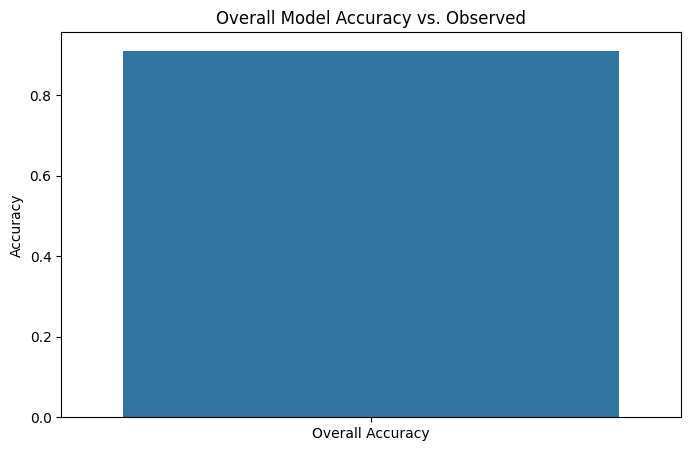

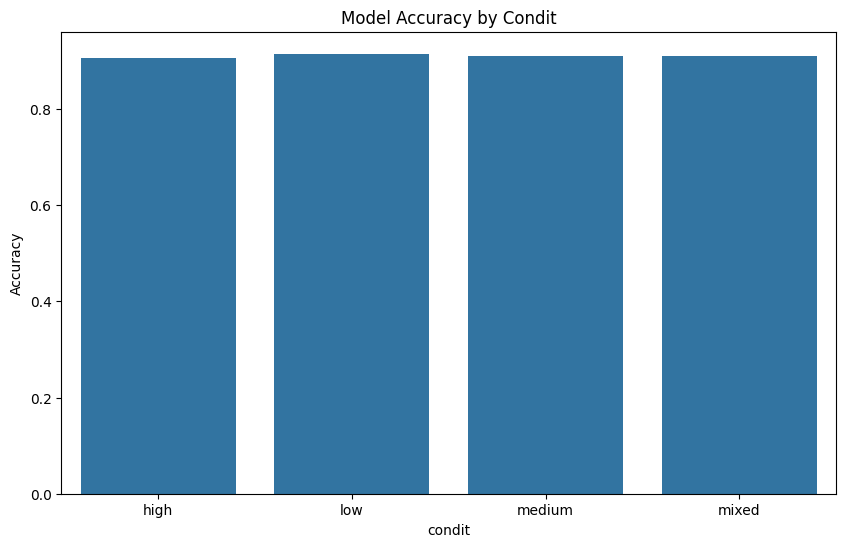

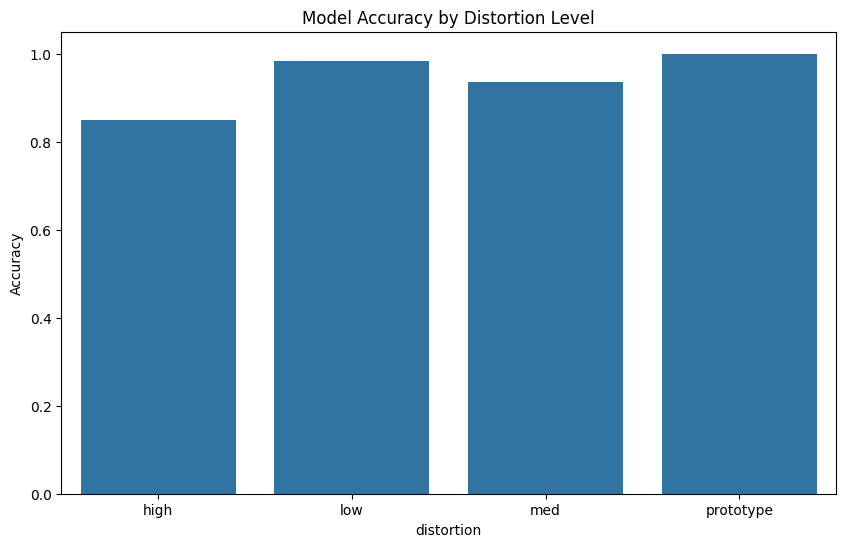

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overall accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x=['Overall Accuracy'], y=[overall_accuracy])
plt.title('Overall Model Accuracy vs. Observed')
plt.ylabel('Accuracy')
plt.show()

# Accuracy by condit
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_by_condit.index, y=accuracy_by_condit.values)
plt.title('Model Accuracy by Condit')
plt.ylabel('Accuracy')
plt.show()

# Accuracy by distortion level
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_by_distortion.index, y=accuracy_by_distortion.values)
plt.title('Model Accuracy by Distortion Level')
plt.ylabel('Accuracy')
plt.show()


Remember to replace `'path_to_your_dataset.csv'` with the actual path to your dataset. Adjust the model architecture, training epochs, and batch size as needed based on your dataset size and computational resources.